# Pyomo.DoE Tutorial: Reaction Kinetics Example 

Jialu Wang (jwang44@nd.edu), Alex Dowling (adowling@nd.edu), and Hailey Lynch (hlynch@nd.edu)

University of Notre Dame

This notebook demonstrates the main features of Pyomo.DoE (model-based design of experiments) using a reaction kinetics example. See [Wang and Dowling (2022), AIChE J.](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.17813), for more information.

The user will be able to learn concepts involved with model-based design of experiments (MBDoE) and practice using Pyomo.DoE from methodology in the notebook. Results will be interpreted throughout the notebook to connect the material with the Pyomo implementation.
    

The general process that will follow throughout this notebook:

Import Modules

* Step 0: Import Pyomo and Pyomo.DoE Module

Problem Statement

* Step 1: Import Reaction Kinetics Example Mathematical Model

Implementation in Pyomo

* Step 2: Implement Mathematical Model in Pyomo
* Step 3: Define Inputs for the Model

Methodology

* Step 4: Method for Computing FIM

* Step 5: Method for Optimization

* Step 6: Method for Exploratory Analysis through Enumeration

Visualizing Results

* Step 7: Results through Heatmaps and Sensitivity Curves

Key Takeaways
* MBDoE maximizes the information gained from experiments which reduces uncertainty (technical risk) and facilitates better decision-making.

* FIM quantifies the information contained in a set of experiments (data) with respect to a mathematical model

* MBDoE optimality criteria (e.g., A, D, E-optimal designs) compress the FIM into a scalar. The "correct" criterion depends on the DoE goal and model context.

* Heatmaps provide visualizations of the most informative parameters using the MBDoE optimality criteria.

## Step 0: Import Pyomo and Pyomo.DoE module

In [1]:
# Ipopt installer
import sys

# If running on Google Colab, install Ipopt via IDAES
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper

    colab_helper.install_idaes()
    colab_helper.install_ipopt()

# Otherwise, attempt to load IDAES which should include Ipopt and k_aug
# See https://idaes-pse.readthedocs.io/en/stable/tutorials/getting_started/index.html
# for instructions on running IDAES get-extensions
else:
    try:
        import idaes

        # Provided IDAES extensions are installed, importing IDAES provides access to
        # Ipopt with HSL and k_aug which are needed for this example
        print("Successfully loaded IDAES.")
    except:
        print(
            "IDAES is not installed. Make sure you have independently installed Ipopt with HSL and k_aug."
        )

Successfully loaded IDAES.


In [2]:
# Imports
import numpy as np
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar
from pyomo.contrib.doe import (
    ModelOptionLib,
    DesignOfExperiments,
    MeasurementVariables,
    DesignVariables,
)

In [3]:
# Check if Ipopt is available
ipopt_available = pyo.SolverFactory("ipopt").available()
if not (ipopt_available):
    raise RuntimeError("This Pyomo.DoE example requires Ipopt.")

## Step 1: Import Reaction Kinetics Example Mathematical Model

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$$

Our ultimate goal is to design a large-scale continuous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmaceuticals, etc.).

The rate laws for these two chemical reactions are:

$$r_A = -k_1 C_A$$

$$r_B = k_1 C_A - k_2 C_B$$

$$r_C = k_2 C_B$$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. 

The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$$k_1 = A_1 \exp{\frac{-E_1}{R T}}$$

$$k_2 = A_2 \exp{\frac{-E_2}{R T}}$$

where:
* $A_1$ [$s^{-1}$], $A_2$ [$s^{-1}$] , $E_1$ [kJ/mol], and $E_2$ [kJ/mol] are fitted model parameters
* $R$ [J/molK] is the ideal-gas constant
* $T$ [K] is absolute temperature

Using the Pyomo ecosystem, we would like to perform **uncertainty quantification** and **design of experiments** on a small-scale batch reactor to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch Reactor

The concentrations in a batch reactor evolve with time and are modeled by the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

We have now established a linear system of differential equations. Next, we can write the initial conditions assuming the feed is only species $A$ such that:

$$C_A(t=0) = C_{A0}, \quad C_B(t=0) = 0, \quad C_C(t=0) = 0$$

When $k_1$ and $k_2$ are at constant temperature, it leads to the following analytic solution:

$$C_A(t) = C_{A0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A0} - \frac{k_2}{k_2 - k_1} C_{A0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A0} = C_{A0} - C_{A}(t) - C_{B}(t)$$

## Implement Mathematical Model in Pyomo

The mathematical model is comprised of a system of differential-algebraic equations (DAEs) which will be solved using Pyomo.DAE.

In [4]:
# Discretize using Pyomo.DAE
def disc_for_measure(m, nfe=32, block=True):
    """
    Pyomo.DAE discretization

    Arguments
    ---------
    m: Pyomo model
    nfe: number of finite elements b
    block: if True, the input model has blocks
    """
    # Discretization using collocation
    discretizer = pyo.TransformationFactory("dae.collocation")
    if block:
        for s in range(len(m.block)):
            discretizer.apply_to(m.block[s], nfe=nfe, ncp=3, wrt=m.block[s].t)
    else:
        discretizer.apply_to(m, nfe=nfe, ncp=3, wrt=m.t)
    return m

Next, create the model.

In [5]:
# Create model
def create_model(
    mod=None,
    model_option="stage2",
    control_time=[0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1],
    control_val=None,
    t_range=[0.0, 1],
    CA_init=1,
    C_init=0.1,
):
    """
    This is an example user model provided to the DoE library.
    It is a dynamic problem solved by Pyomo.DAE.

    Arguments
    ---------
    mod: Pyomo model. If None, a Pyomo concrete model is created
    model_option: choose from the 3 options in model_option
        if ModelOptionLib.parmest, create a process model.
        if ModelOptionLib.stage1, create the global model.
        if ModelOptionLib.stage2, add model variables and constraints for block.
    control_time: a list of control timepoints
    control_val: control design variable values T at corresponding timepoints
    t_range: time range, hours
    CA_init: time-independent design (control) variable, an initial value for CA
    C_init: An initial value for C

    Return
    ------
    m: a Pyomo.DAE model
    """
    # Parameter initialization; results from parameter estimation
    theta = {"A1": 84.79, "A2": 371.72, "E1": 7.78, "E2": 15.05}

    # Model option
    model_option = ModelOptionLib(model_option)

    if model_option == ModelOptionLib.parmest:
        mod = pyo.ConcreteModel()
        return_m = True
    elif model_option == ModelOptionLib.stage1 or model_option == ModelOptionLib.stage2:
        if not mod:
            raise ValueError(
                "If model option is stage1 or stage2, a created model needs to be provided."
            )
        return_m = False
    else:
        raise ValueError(
            "model_option needs to be defined as parmest, stage1, or stage2."
        )

    # Control value
    if not control_val:
        control_val = [300] * 9

    # Control time
    controls = {}
    for i, t in enumerate(control_time):
        controls[t] = control_val[i]

    mod.t0 = pyo.Set(initialize=[0])
    mod.t_con = pyo.Set(initialize=control_time)
    mod.CA0 = pyo.Var(
        mod.t0, initialize=CA_init, bounds=(1.0, 5.0), within=pyo.NonNegativeReals
    )  # mol/L

    # Check if control_time is in time range
    assert (
        control_time[0] >= t_range[0] and control_time[-1] <= t_range[1]
    ), "control time is outside time range."

    if model_option == ModelOptionLib.stage1:
        mod.T = pyo.Var(
            mod.t_con,
            initialize=controls,
            bounds=(300, 700),
            within=pyo.NonNegativeReals,
        )
        return

    else:
        para_list = ["A1", "A2", "E1", "E2"]

        # Add variables
        mod.CA_init = CA_init
        mod.para_list = para_list

        # Timepoints
        mod.t = ContinuousSet(bounds=t_range, initialize=control_time)

        # Time-dependent design variable; initialized with the first control value
        def T_initial(m, t):
            if t in m.t_con:
                return controls[t]
            else:
                # Count how many control points are before the current t;
                # Locate the nearest neighbouring control point before this t
                neighbour_t = max(tc for tc in control_time if tc < t)
                return controls[neighbour_t]

        mod.T = pyo.Var(
            mod.t, initialize=T_initial, bounds=(300, 700), within=pyo.NonNegativeReals
        )

        # Gas constant
        mod.R = 8.31446261815324  # J / K / mole

        # Define variables as Var
        mod.A1 = pyo.Var(initialize=theta["A1"])
        mod.A2 = pyo.Var(initialize=theta["A2"])
        mod.E1 = pyo.Var(initialize=theta["E1"])
        mod.E2 = pyo.Var(initialize=theta["E2"])

        # Concentration variables under perturbation
        mod.C_set = pyo.Set(initialize=["CA", "CB", "CC"])
        mod.C = pyo.Var(
            mod.C_set, mod.t, initialize=C_init, within=pyo.NonNegativeReals
        )

        # Time derivative of C
        mod.dCdt = DerivativeVar(mod.C, wrt=mod.t)

        # Kinetic parameters
        def kp1_init(m, t):
            return m.A1 * pyo.exp(-m.E1 * 1000 / (m.R * m.T[t]))

        def kp2_init(m, t):
            return m.A2 * pyo.exp(-m.E2 * 1000 / (m.R * m.T[t]))

        mod.kp1 = pyo.Var(mod.t, initialize=kp1_init)
        mod.kp2 = pyo.Var(mod.t, initialize=kp2_init)

        def T_control(m, t):
            """
            Time is discretized for numeric integration. A subset of these time points are control time points.
            Temperature is constant within each control time point.

            TODO: replace this function with reduce_collocation_points
            https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html

            """
            if t in m.t_con:
                return pyo.Constraint.Skip
            else:
                neighbour_t = max(tc for tc in control_time if tc < t)
                return m.T[t] == m.T[neighbour_t]

        def cal_kp1(m, t):
            """
            Create the perturbation parameter sets for A --> B reaction

            m: model
            t: time
            """
            # LHS: 1/h
            # RHS: 1/h*(kJ/mol *1000J/kJ / (J/mol/K) / K)
            return m.kp1[t] == m.A1 * pyo.exp(-m.E1 * 1000 / (m.R * m.T[t]))

        def cal_kp2(m, t):
            """
            Create the perturbation parameter sets for B --> C reaction

            m: model
            t: time
            """
            # LHS: 1/h
            # RHS: 1/h*(kJ/mol *1000J/kJ / (J/mol/K) / K)
            return m.kp2[t] == m.A2 * pyo.exp(-m.E2 * 1000 / (m.R * m.T[t]))

        def dCdt_control(m, y, t):
            """
            Calculate CA in Jacobian matrix analytically

            y: CA, CB, CC
            t: timepoints
            """
            if y == "CA":
                return m.dCdt[y, t] == -m.kp1[t] * m.C["CA", t]
            elif y == "CB":
                return m.dCdt[y, t] == m.kp1[t] * m.C["CA", t] - m.kp2[t] * m.C["CB", t]
            elif y == "CC":
                return pyo.Constraint.Skip

        def alge(m, t):
            """
            The algebraic equation for mole balance

            z: m.pert
            t: time
            """
            return m.C["CA", t] + m.C["CB", t] + m.C["CC", t] == m.CA0[0]

        # Control time
        mod.T_rule = pyo.Constraint(mod.t, rule=T_control)

        # Calculating C, Jacobian, FIM
        mod.k1_pert_rule = pyo.Constraint(mod.t, rule=cal_kp1)
        mod.k2_pert_rule = pyo.Constraint(mod.t, rule=cal_kp2)
        mod.dCdt_rule = pyo.Constraint(mod.C_set, mod.t, rule=dCdt_control)

        mod.alge_rule = pyo.Constraint(mod.t, rule=alge)

        # Boundary conditions
        mod.C["CB", 0.0].fix(0.0)
        mod.C["CC", 0.0].fix(0.0)

        if return_m:
            return mod

In [6]:
# The above models are alternately available in the examples folder:
# from pyomo.contrib.doe.examples.reactor_kinetics import create_model, disc_for_measure

## Step 3: Define Inputs for the Model

In [7]:
# Control time set [h]
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
# Define parameter nominal value
parameter_dict = {"A1": 84.79, "A2": 371.72, "E1": 7.78, "E2": 15.05}

In [8]:
# Pyomo.DoE defines measurements
# Measurements have at most 1 index besides the time index
variable_name = "C"
indices = {0: ["CA", "CB", "CC"], 1: t_control}

# Measurement class
measure_class = MeasurementVariables()
measure_class.add_variables(variable_name, indices=indices, time_index_position=1)
print("measurement names:", measure_class.variable_names)

measurement names: ['C[CA,0]', 'C[CA,0.125]', 'C[CA,0.25]', 'C[CA,0.375]', 'C[CA,0.5]', 'C[CA,0.625]', 'C[CA,0.75]', 'C[CA,0.875]', 'C[CA,1]', 'C[CB,0]', 'C[CB,0.125]', 'C[CB,0.25]', 'C[CB,0.375]', 'C[CB,0.5]', 'C[CB,0.625]', 'C[CB,0.75]', 'C[CB,0.875]', 'C[CB,1]', 'C[CC,0]', 'C[CC,0.125]', 'C[CC,0.25]', 'C[CC,0.375]', 'C[CC,0.5]', 'C[CC,0.625]', 'C[CC,0.75]', 'C[CC,0.875]', 'C[CC,1]']


In [9]:
# Design variables
design_gen = DesignVariables()

var_C = "CA0"
indices_C = {0: [0]}
exp1_C = [5]

# Add design variable
design_gen.add_variables(
    var_C,
    indices=indices_C,
    time_index_position=0,
    values=exp1_C,
    lower_bounds=1,
    upper_bounds=5,
)


var_T = "T"
indices_T = {0: t_control}
exp1_T = [470, 300, 300, 300, 300, 300, 300, 300, 300]

design_gen.add_variables(
    var_T,
    indices=indices_T,
    time_index_position=0,
    values=exp1_T,
    lower_bounds=300,
    upper_bounds=700,
)
print("Design variable names:", design_gen.variable_names)

Design variable names: ['CA0[0]', 'T[0]', 'T[0.125]', 'T[0.25]', 'T[0.375]', 'T[0.5]', 'T[0.625]', 'T[0.75]', 'T[0.875]', 'T[1]']


In [10]:
# Parameter dictionary
param_dict = {"A1": 84.79, "A2": 371.72, "E1": 7.78, "E2": 15.05}

## Step 4: Method for Computing FIM 

This method computes an FIM-based MBDoE optimization problem with zero degrees of freedom.

### Fisher Information Matrix (FIM)
The FIM measures the information content for the unknown parameters $\theta$ from the model output $y_i$ given that:

$$ y_i = f(\psi_i, \theta) $$

where $\psi$ is a design vector from a DAE system.

In order to quantify the uncertainty of the estimated parameters for parameter estimation, consider the covariance matrix for the parameters:

$$V(\hat{\theta},\psi) = \left[\sum_{r}^{N_{r}}\sum_{r'}^{N_{r}} \tilde{\sigma}_{(r,r')}Q_{r}^{T}Q_{r'}+V_{\theta}(\hat{\theta})^{-1}\right]^{-1}$$

where:
* $\hat{\theta}$: estimated parameters
* $\tilde{\sigma}$: element in the inverse of the observational covariance matrix
* $r,$ $r'$: measurements
* $Q$: dynamic sensitivity
* $V_{\theta}$: prior information
* $N_r$: number of measurements

The inverse of $V$ estimates the FIM such that:

$$V(\hat{\theta},\psi) \approx [M(\hat{\theta},\psi)]^{-1}$$

For sequential design of experiments, consider prior information such that after $N_e$ dynamic experiments, the FIM is calculated by:
$$M= \sum_{k=1}^{N_e-1}M_k+M_{N_e}(\hat{\theta},\psi_{N_e}) = K+M_{N_e}(\hat{\theta},\psi_{N_e})$$

where:
* $N_e - 1$: previous experiments
* $K$: constant matrix encoding information from all $N_e - 1$

**Key Takeaway**:
A **large** FIM value denotes **more** information about $\theta$ is gained from the model

### Model-Based Design of Experiments
The objective of MBDoE changes the conditions of one or more experiments based on a specific purpose such as:

1. Model identification
    * Discriminates between possible models while omitting inadequate models
2. Parameter estimation
    * Improves parameter estimation precision

**Key Takeaways:**
Given an estimate for an unknown parameter and one or more mathematical models, MBDoE:
1. Determines a set of experimental conditions to maximize the precision of the unknown model parameters
2. Discriminates between the given models
3. Or both (1) and (2)

Currently, Pyomo.DoE supports MBDoE for parameter precision.

In [11]:
# Choose from 'sequential_finite', 'direct_kaug'
# sensi_opt = "direct_kaug"
sensi_opt = "sequential_finite"

# Define experiments
design_names = design_gen.variable_names
exp1 = [5, 470, 300, 300, 300, 300, 300, 300, 300, 300]
exp1_design_dict = dict(zip(design_names, exp1))

# Update values
design_gen.update_values(exp1_design_dict)

In [12]:
# Create doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(
    parameter_dict,  # dictionary of parameters
    design_gen,  # design variable
    measure_class,  # measurement variable
    create_model,  # model
    discretize_model=disc_for_measure,  # discretized model
)

# Computing the FIM
result = doe_object.compute_FIM(
    mode=sensi_opt,  # solver option for sensitivity optimization
    FIM_store_name="dynamic.csv",  # csv file that stores FIM data
    read_output=None,  # outputs from stored file; do not have to rerun since there are measurement values already
    scale_nominal_param_value=True,  # scale the Jacobian with the parameter values
    formula="central",  # finite difference - central method
)

# Results
result.result_analysis()

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [13]:
# Results summary
print("======Results Summary======")
print("Four design criteria log10() value:")
print("A-optimality:", np.log10(result.trace))
print("D-optimality:", np.log10(result.det))
print("E-optimality:", np.log10(result.min_eig))
print("Modified E-optimality:", np.log10(result.cond))
print(result.FIM)

======Results Summary======
Four design criteria log10() value:
A-optimality: 2.989724462425373
D-optimality: 3.3010989022733894
E-optimality: -0.9193349136200465
Modified E-optimality: 3.87680755495709
[[  17.22096879   13.67125453  -37.1471375   -68.68858407]
 [  13.67125453   34.5737961   -26.37449298 -170.10871631]
 [ -37.1471375   -26.37449298   81.32448107  133.30724227]
 [ -68.68858407 -170.10871631  133.30724227  843.49816474]]


### Optimality Conditions
**D-Optimality:** Maximizes the determinant of $M$ or minimizes the determinant of $V$ 	
* Computation: Determinant
* Geometric interpretation: Minimizes the volume of the  confidence ellipsoid 

**A-Optimality:** Maximizes the trace of $M$ or minimizes the trace of $V$             	
* Computation: Trace            	
* Geometric interpretation: Minimizes the dimensions of the enclosing box around the confidence ellipsoid 	

**E-Optimality:** Minimizes the variance of the  most uncertain parameter       	 
* Computation: Eigenvalue       	
* Geometric interpretiation: Minimizes the size of the major axis of the confidence ellipsoid  

**Modified E-Optimality:** Reduces the correlations between parameters                   	 
* Computation: Condition number 	 
* Geometric interpretation: Transforms the confidence ellipsoid into a round sphere   

In [14]:
# Choose a subset of measurements and get the results without resolving the model
sub_name = "C"
sub_indices = {0: ["CB", "CC"], 1: [0.125, 0.25, 0.5, 0.75, 0.875]}

# Measurement subset
measure_subset = MeasurementVariables()
measure_subset.add_variables(sub_name, indices=sub_indices, time_index_position=1)
print(measure_subset.variable_names)

['C[CB,0.125]', 'C[CB,0.25]', 'C[CB,0.5]', 'C[CB,0.75]', 'C[CB,0.875]', 'C[CC,0.125]', 'C[CC,0.25]', 'C[CC,0.5]', 'C[CC,0.75]', 'C[CC,0.875]']


In [15]:
# Subset results summary
sub_result = result.subset(measure_subset)
sub_result.result_analysis()
print("======Subset Results Summary======")
print("Four design criteria log10() value:")
print("A-optimality:", np.log10(sub_result.trace))
print("D-optimality:", np.log10(sub_result.det))
print("E-optimality:", np.log10(sub_result.min_eig))
print("Modified E-optimality:", np.log10(sub_result.cond))

======Subset Results Summary======
Four design criteria log10() value:
A-optimality: 2.7312606650205398
D-optimality: 1.8213450338458799
E-optimality: -1.430816119614162
Modified E-optimality: 4.147090377578492


## Step 5: Method for Optimization
Gradient-based optimization with Ipopt using stochastic_program().

We first fix the experiment design decisions and solve the simulation problem (zero degrees of freedom). This facilitates initialization.

Next, we unfix the experiment design variables and resolve the optimization problem (positive number of degrees of freedom).

This allows us to compute the best time-varying piecewise-constant temperature profile for the batch reactor experiment.

In [16]:
# Experiment
exp1 = [5, 500, 300, 300, 300, 300, 300, 300, 300, 300]
exp1_design_dict = dict(zip(design_names, exp1))
design_gen.update_values(exp1_design_dict)

# Add prior information (scaled FIM with T=500 and T=300 experiments)
prior = np.asarray(
    [
        [28.67892806, 5.41249739, -81.73674601, -24.02377324],
        [5.41249739, 26.40935036, -12.41816477, -139.23992532],
        [-81.73674601, -12.41816477, 240.46276004, 58.76422806],
        [-24.02377324, -139.23992532, 58.76422806, 767.25584508],
    ]
)

In [17]:
# Create doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(
    parameter_dict,  # dictionary of parameters
    design_gen,  # design variable
    measure_class,  # measurement variable
    create_model,  # model
    prior_FIM=prior,  # FIM of prior experiments
    discretize_model=disc_for_measure,  # discretized model
)

# Stochastic programming for optimization; see above for how the function solves twice
square_result, optimize_result = doe_object.stochastic_program(
    if_optimize=True,  # optimize
    if_Cholesky=True,  # use Cholesky decomposition
    scale_nominal_param_value=True,  # scale model parameter value
    objective_option="det",  # objective option
    L_initial=np.linalg.cholesky(prior),  # initial Cholesky decomposition
)

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

INFO: elapsed time: 5.6


In [18]:
# Results summary
print("======Results Summary======")
print("This optimization is solved with status:", optimize_result.status)
print("C solution:", pyo.value(optimize_result.model.CA0[0]))
print("T solution:")
for t in t_control:
    print(pyo.value(optimize_result.model.T[t]))

print("The result FIM is: \n", optimize_result.FIM)
print("Four design criteria log10() value:")
print("A-optimality:", np.log10(optimize_result.trace))
print("D-optimality:", np.log10(optimize_result.det))
print("E-optimality:", np.log10(optimize_result.min_eig))
print("Modified E-optimality:", np.log10(optimize_result.cond))

======Results Summary======
This optimization is solved with status: converged
C solution: 5.0
T solution:
579.3896781590472
300.00008825998646
300.0001449066281
300.0002011134464
300.00026910716224
300.00037503303196
300.00058304040493
300.00119444148544
300.00410830698996
The result FIM is: 
 [[  46.26165475   24.02303687 -111.13766257  -98.84248628]
 [  24.02303687   56.00005105  -41.78107762 -257.31551935]
 [-111.13766257  -41.78107762  290.39184707  177.30569633]
 [ -98.84248628 -257.31551935  177.30569633 1245.5926873 ]]
Four design criteria log10() value:
A-optimality: 3.2143791799119263
D-optimality: 6.214368093237916
E-optimality: 0.007877626397731468
Modified E-optimality: 3.1198074131681715


## Step 6: Method for Exploratory Analysis through Enumeration

This method conducts exploratory analysis using enumeration. 
It allows a user to define any number (dimensions) of design variables.

### Specify user inputs

In [19]:
# Design variable ranges as lists
design_ranges = {
    "CA0[0]": [1, 3, 5],
    (
        "T[0]",
        "T[0.125]",
        "T[0.25]",
        "T[0.375]",
        "T[0.5]",
        "T[0.625]",
        "T[0.75]",
        "T[0.875]",
        "T[1]",
    ): [300, 500, 700],
}

# Choose from 'sequential_finite', 'direct_kaug'
# sensi_opt = "sequential_finite"
sensi_opt = "direct_kaug"

In [20]:
# Add prior information
prior_pass = [
    [22.52943024, 1.84034314, -70.23273336, -11.09432962],
    [1.84034314, 18.09848116, -5.73565034, -109.15866135],
    [-70.23273336, -5.73565034, 218.94192843, 34.57680848],
    [-11.09432962, -109.15866135, 34.57680848, 658.37644634],
]

# Print prior information
print("The prior information FIM:\n", prior_pass)
print("Prior Det:", np.linalg.det(prior_pass))

The prior information FIM:
 [[22.52943024, 1.84034314, -70.23273336, -11.09432962], [1.84034314, 18.09848116, -5.73565034, -109.15866135], [-70.23273336, -5.73565034, 218.94192843, 34.57680848], [-11.09432962, -109.15866135, 34.57680848, 658.37644634]]
Prior Det: 1.9558434494323278e-08


In [21]:
# Create doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(
    parameter_dict,  # dictionary of parameters
    design_gen,  # design variable
    measure_class,  # measurement variable
    create_model,  # model
    prior_FIM=prior_pass,  # FIM of prior experiments
    discretize_model=disc_for_measure,  # discretized model
)
# Grid search
all_fim = doe_object.run_grid_search(
    design_ranges,  # range of design variables
    mode=sensi_opt,  # solver option for sensitivity
)

INFO: =======Iteration Number: 1 =====
INFO: elapsed time: 1.5
INFO: This is run 1 out of 9.
INFO: The code has run  1.4800095079999664 seconds.
INFO: Estimated remaining time:  5.180033277999883 seconds
INFO: =======Iteration Number: 2 =====
INFO: elapsed time: 0.8
INFO: This is run 2 out of 9.
INFO: The code has run  2.2786834119997366 seconds.
INFO: Estimated remaining time:  4.557366823999473 seconds
INFO: =======Iteration Number: 3 =====
INFO: elapsed time: 0.8
INFO: This is run 3 out of 9.
INFO: The code has run  3.0774706169995625 seconds.
INFO: Estimated remaining time:  3.846838271249453 seconds
INFO: =======Iteration Number: 4 =====
INFO: elapsed time: 0.6
INFO: This is run 4 out of 9.
INFO: The code has run  3.6389742199989996 seconds.
INFO: Estimated remaining time:  2.9111793759991995 seconds
INFO: =======Iteration Number: 5 =====
INFO: elapsed time: 0.8
INFO: This is run 5 out of 9.
INFO: The code has run  4.463020823998704 seconds.
INFO: Estimated remaining time:  2.2315

## Step 7: Results through Sensitivity Curves and Heatmaps

### 1D Sensitivity Curve

1D sensitivity curves can be drawn by one design variable and fixing other design variables.

   CA0[0]  \
0     1.0   
1     1.0   
2     1.0   
3     3.0   
4     3.0   
5     3.0   
6     5.0   
7     5.0   
8     5.0   

   (T[0], T[0.125], T[0.25], T[0.375], T[0.5], T[0.625], T[0.75], T[0.875], T[1])  \
0                                              300.0                                
1                                              500.0                                
2                                              700.0                                
3                                              300.0                                
4                                              500.0                                
5                                              700.0                                
6                                              300.0                                
7                                              500.0                                
8                                              700.0                                

            A     

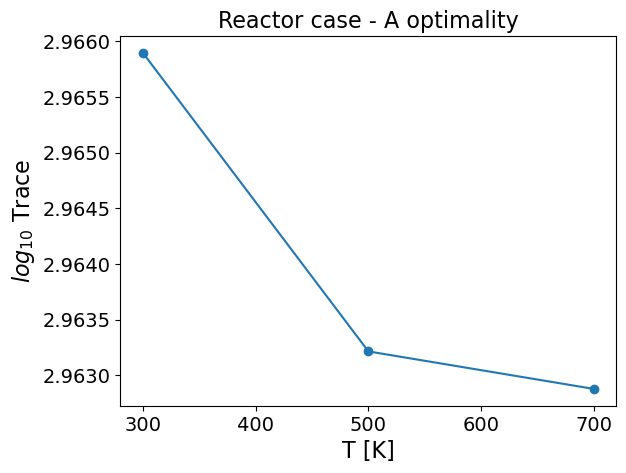

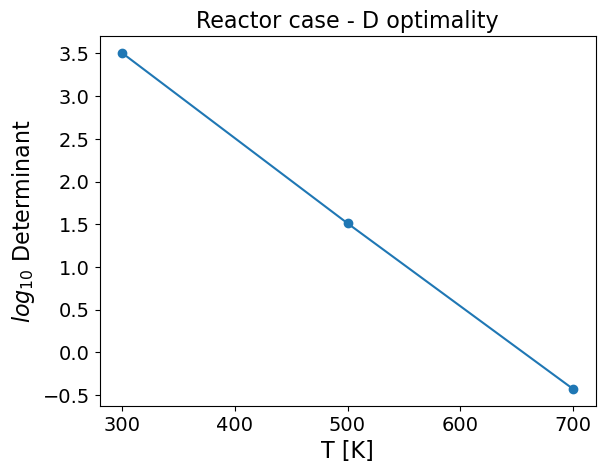

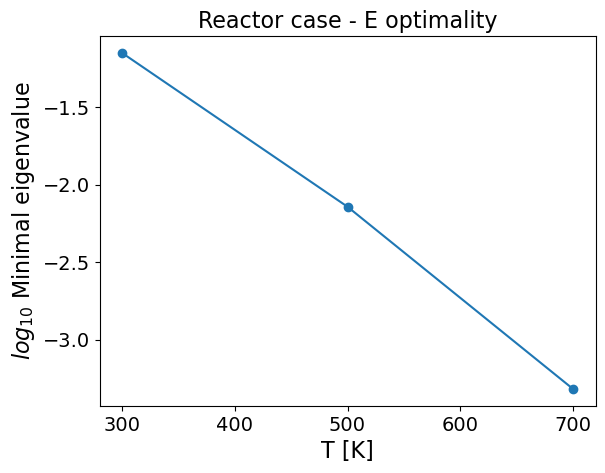

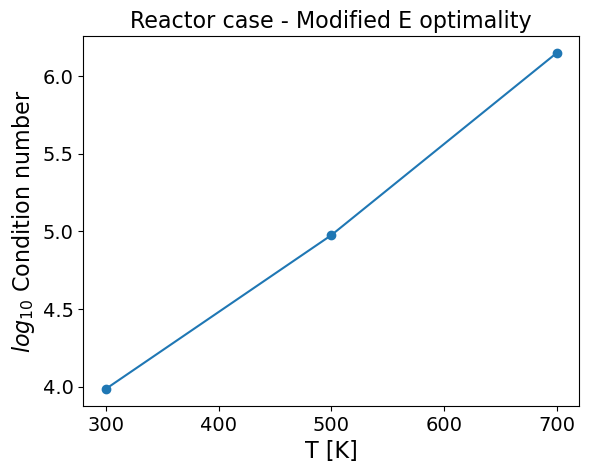

In [22]:
# Extract criteria from FIM
all_fim.extract_criteria()
print(all_fim.store_all_results_dataframe)

# Draw 1D sensitivity curve
# This problem has two degrees of freedom; to draw a 1D curve, it needs to fix one dimension
fixed = {"'CA0[0]'": 5.0}

all_fim.figure_drawing(
    fixed,
    [
        (
            "T[0]",
            "T[0.125]",
            "T[0.25]",
            "T[0.375]",
            "T[0.5]",
            "T[0.625]",
            "T[0.75]",
            "T[0.875]",
            "T[1]",
        )
    ],
    "Reactor case",
    "T [K]",
    "$C_{A0}$ [M]",
)

### Heatmaps

Heatmaps can be drawn using two design variables and fixing other design variables.

### Interpreting Heatmaps

A heatmap shows the change of the objective function (the experimental information content) in the design region. 

Horizontal and vertical axes are two design variables, while the color of each grid shows the experimental information content.

The color of each grid is based on a gradient of information. A darker color refers to an area with more information content whereas the lighter color refers to an area with less information content.

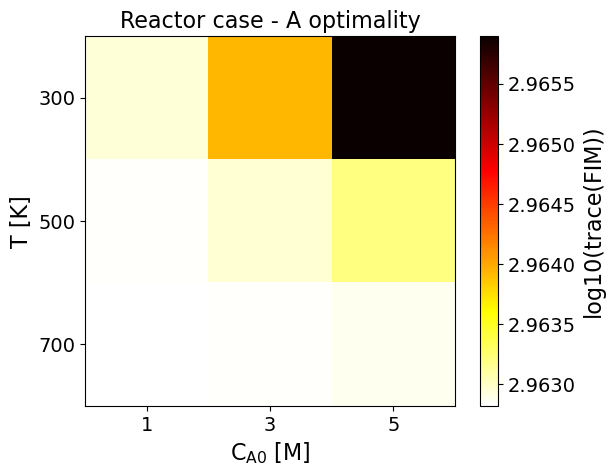

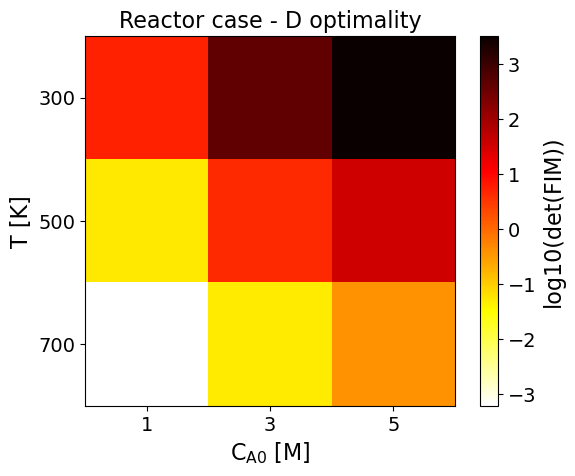

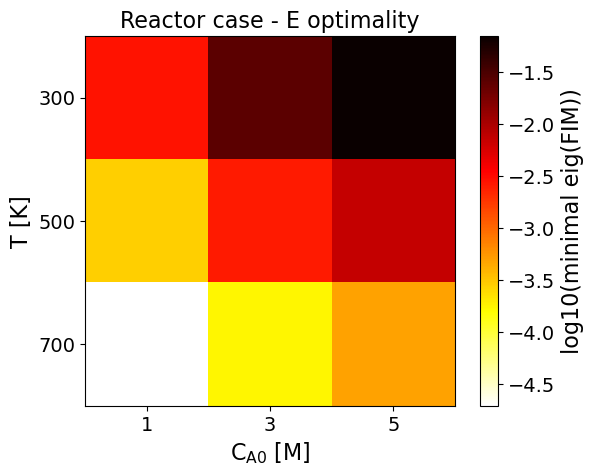

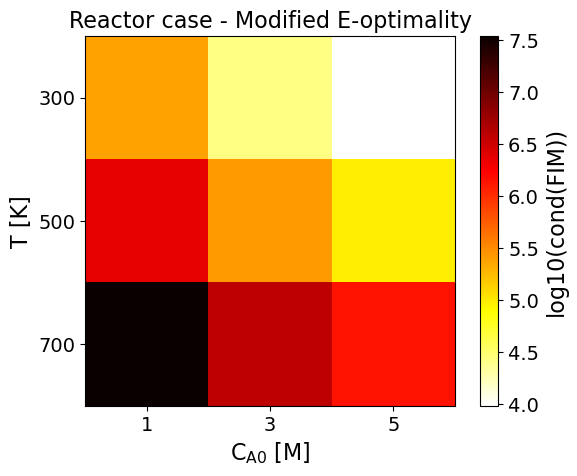

In [23]:
# This problem has two degrees of freedom. Fixing dimensions are not necessary for drawing a heatmap

fixed = {}
all_fim.figure_drawing(
    fixed, ["CA0[0]", "T[0]"], "Reactor case", "$C_{A0}$ [M]", "T [K]"
)

### Grid Search for 3 Design Variables

In [24]:
# Define design ranges
design_ranges = {
    "CA0[0]": list(np.linspace(1, 5, 2)),
    "T[0]": list(np.linspace(300, 700, 2)),
    (
        "T[0.125]",
        "T[0.25]",
        "T[0.375]",
        "T[0.5]",
        "T[0.625]",
        "T[0.75]",
        "T[0.875]",
        "T[1]",
    ): [300, 500],
}

# Choose from 'sequential_finite', 'direct_kaug'
sensi_opt = "direct_kaug"

In [25]:
# Create doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(
    parameter_dict,  # dictionary of parameters
    design_gen,  # design variable
    measure_class,  # measurement variable
    create_model,  # model
    prior_FIM=prior_pass,  # FIM of prior experiments
    discretize_model=disc_for_measure,  # discretized model
)

# Run grid search
all_fim = doe_object.run_grid_search(
    design_ranges,  # range of design variables
    mode=sensi_opt,  # solver option for sensitivity
)

INFO: =======Iteration Number: 1 =====
INFO: elapsed time: 0.8
INFO: This is run 1 out of 8.
INFO: The code has run  0.8139118879998932 seconds.
INFO: Estimated remaining time:  2.4417356639996797 seconds
INFO: =======Iteration Number: 2 =====
INFO: elapsed time: 0.8
INFO: This is run 2 out of 8.
INFO: The code has run  1.6158038199992006 seconds.
INFO: Estimated remaining time:  2.693006366665334 seconds
INFO: =======Iteration Number: 3 =====
INFO: elapsed time: 0.6
INFO: This is run 3 out of 8.
INFO: The code has run  2.2149686929988093 seconds.
INFO: Estimated remaining time:  2.2149686929988093 seconds
INFO: =======Iteration Number: 4 =====
INFO: elapsed time: 1.0
INFO: This is run 4 out of 8.
INFO: The code has run  3.1933937759986293 seconds.
INFO: Estimated remaining time:  1.9160362655991774 seconds
INFO: =======Iteration Number: 5 =====
INFO: elapsed time: 0.6
INFO: This is run 5 out of 8.
INFO: The code has run  3.7590698399981193 seconds.
INFO: Estimated remaining time:  1.2

### Draw 1D Sensitivity Curve

In [26]:
# FIM criteria
test = all_fim.extract_criteria()

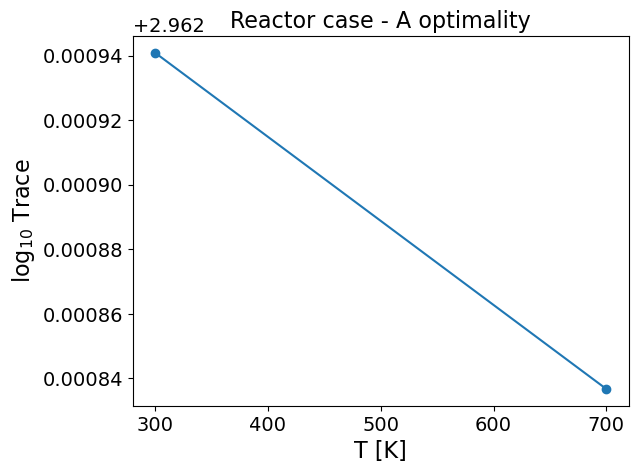

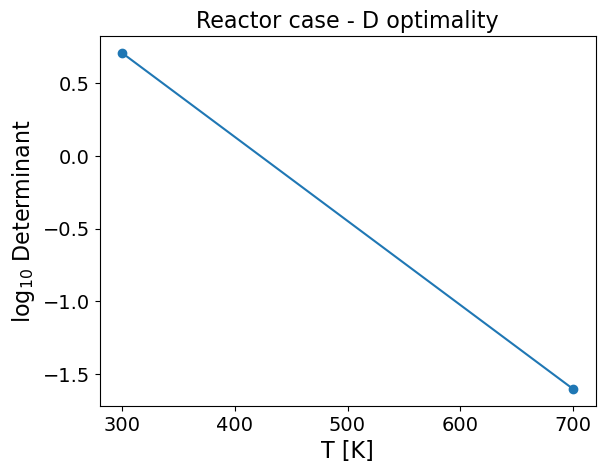

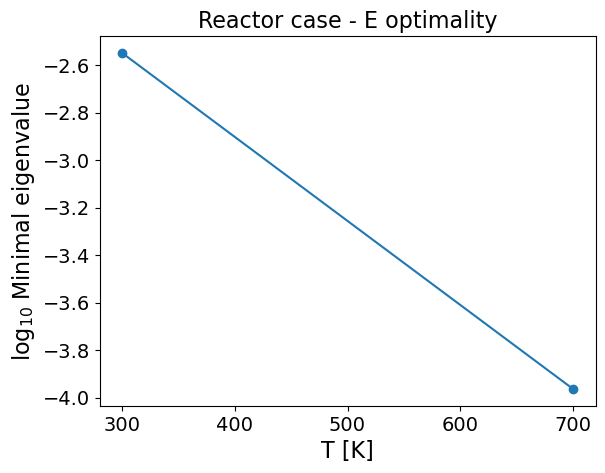

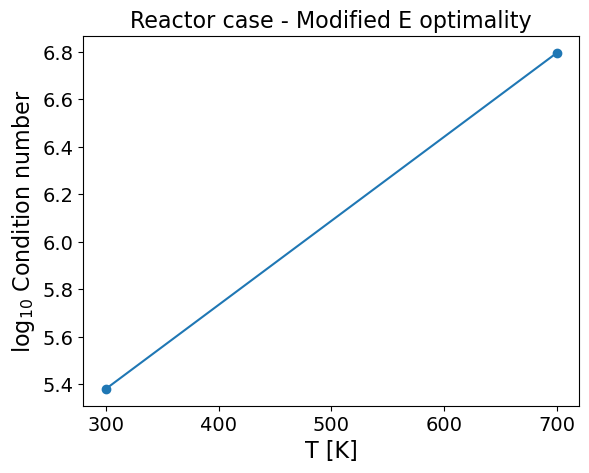

In [27]:
# Draw 1D sensitivity curve
# This problem has three degrees of freedom. To draw the 1D curve, it needs to fix two dimensions
fixed = {
    "'CA0[0]'": 1.0,
    "('T[0.125]','T[0.25]','T[0.375]','T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]')": 300,
}

all_fim.figure_drawing(fixed, ["T[0]"], "Reactor case", "T [K]", "$C_{A0}$ [M]")

### Draw 2D Sensitivity Curve

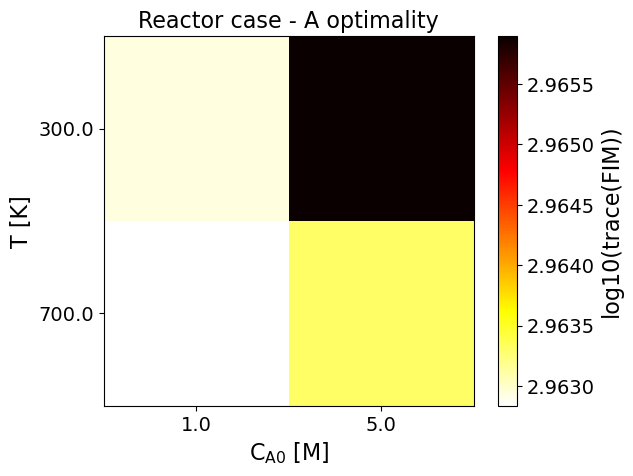

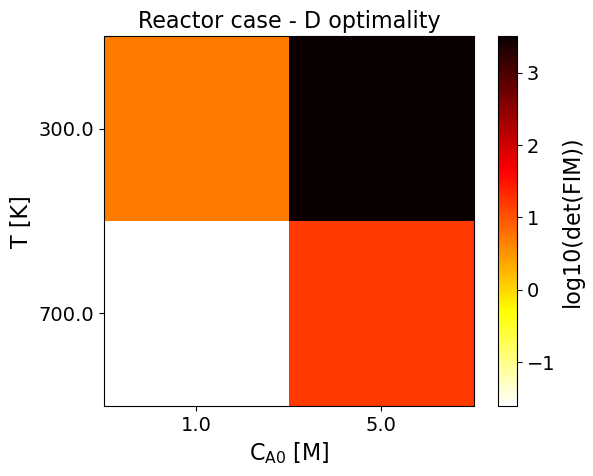

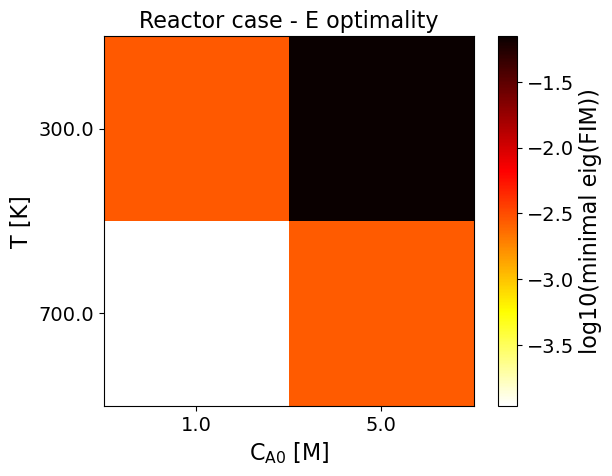

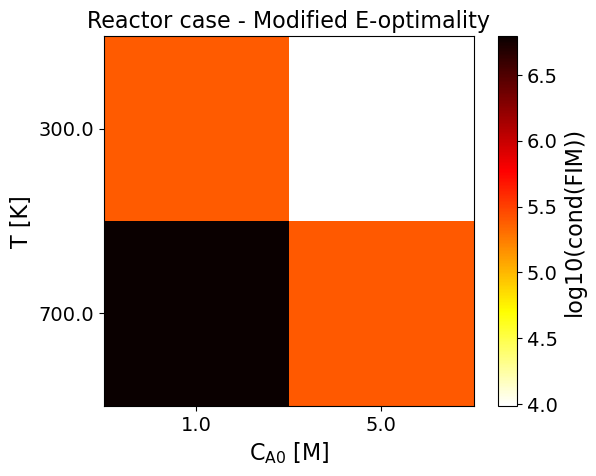

In [28]:
# This problem has three degrees of freedom. To draw the heatmap, it needs to fix one dimension
fixed = {
    "('T[0.125]','T[0.25]','T[0.375]','T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]')": 300
}

all_fim.figure_drawing(
    fixed, ["CA0[0]", "T[0]"], "Reactor case", "$C_{A0}$ [M]", "T [K]"
)

As seen in the Reactor Case - A optimality figure, A-optimality shows that the most informative region is around $C_{A0}=5.0$ M, $T=300.0$ K, while the least informative region is around $C_{A0}=1.0$ M, $T=700.0$ K.

As seen in the Reactor Case - D optimality figure, D-optimality shows that the most informative region is around $C_{A0}=5.0$ M, $T=300.0$ K, while the least informative region is around $C_{A0}=1.0$ M, $T=700.0$ K.

As seen in the Reactor Case - E optimality figure, E-optimality shows that the most informative region is around $C_{A0}=5.0$ M, $T=300.0$ K, while the least informative region is around $C_{A0}=1.0$ M, $T=700.0$ K.

As seen in the Reactor Case - Modified E optimality figure, ME-optimality shows that the most informative region is around $C_{A0}=1.0$ M, $T=700.0$ K, while the least informative region is around $C_{A0}=5.0$ M, $T=300.0$ K.

## Key Takeaways

* MBDoE maximizes the information gained from experiments which reduces uncertainty (technical risk) and facilitates better decision-making.

* FIM quantifies the information contained in a set of experiments (data) with respect to a mathematical model

* MBDoE optimality criteria (e.g., A, D, E-optimal designs) compress the FIM into a scalar. The "correct" criterion depends on the DoE goal and model context.

* Heatmaps provide visualizations of the most informative parameters using the MBDoE optimality criteria.